In [2]:
from pycaret.datasets import get_data
from pycaret.regression import *

import pandas as pd
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["xtick.labelsize"] = 6
mpl.rcParams["ytick.labelsize"] = 6
mpl.rcParams["axes.labelsize"] = 6
mpl.rcParams["legend.fontsize"] = 6
mpl.rcParams["legend.title_fontsize"] = 6
# mpl.rcParams["legend.shadow"] = True


# for key, value in mpl.rcParams.items():
#     print(key, "=", value)


> Nota:
> Se trabajó sobre la versión 2.3.4, ya que fue la usada por el autor del libro estudio. También para evitar conflictos con librerías y versiones de Python (2023-09-04 actualmente numba no funciona en python 3.11 o superior).


In [3]:
pycaret.__version__


'2.3.4'

> Data

This is a health insurance dataset, where the features are various attributes including age, sex, Body Mass Index (BMI), whether the person is a smoker or not, number of children and US region. Furthermore, the dataset target variable is the billed charges for every individual


In [4]:
data = get_data("insurance")
# data.select_dtypes(include=["number"]).hist(bins=30, figsize=(6, 4))
# plt.show()

numeric = ["age", "bmi", "children", "charges"]
# data[numeric].hist(bins=20, figsize = (12,8))
# plt.show()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
categorical = ["smoker", "sex", "region"]
color = ["C0", "C1", "C2", "C3"]
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# axes[1, 1].set_axis_off()
# for ax, col in zip(axes.flatten(), categorical):
#     data[col].value_counts().plot(kind="bar", ax=ax, color=color)
#     ax.set_xlabel(col)


> Regression A

Relationship between numeric and categorical variables by using hue mapping. In this case, we plot the target variable histogram, colored differently for every category of the smoker, sex and region variables. Evidently, smokers get significantly higher charges compared to non-smokers. This is expected, as the health risks associated with smoking are
numerous and well-documented.


In [6]:
# fig, axes = plt.subplots(2, 2, figsize=(9, 6))
# axes[1, 1].set_axis_off()
# for ax, col in zip(axes.flatten(), categorical):
#     sns.histplot(data, x="charges", hue=col, multiple="stack", ax=ax)


> Regression B

Scatter plots are a type of visualization that helps us understand the relationship between numeric variables. The pairplot() Seaborn function creates a grid of scatter plots for all pairs of numeric variables in a given dataset. The diagonal contains distribution plots of the variables, such as histograms or KDE plots in this case. Once again, we use hue mapping to highlight the differences between smokers and nonsmokers. As we can see, age is correlated with charges, i.e. people get higher charges as they grow older. In spite of that, being a non-smoker keeps the cost lower for most people, regardless of their age. Furthermore, overweight and obese people don’t seem
to get significantly higher charges, unless they are also smokers.


In [7]:
cols = ["age", "bmi", "charges", "smoker"]
# sns.pairplot(data[cols], hue='smoker')
# plt.show()


> Pycaret environment


In [8]:
reg = setup(
    data=data,
    target="charges",
    train_size=0.8,
    session_id=123,
    numeric_features=numeric[:-1],
    categorical_features=categorical,
    transformation=True,
    normalize=True,
    transform_target=True,
    # one_hot_encoding=True
)


,Description,Value
0,session_id,123
1,Target,charges
2,Original Data,"(1338, 7)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1070, 9)"


In [9]:
# model = create_model('gbr', fold = 10)


In [10]:
get_config("X").head()


,age,bmi,children,sex_female,smoker_no,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.444766,-0.417859,-1.034700,1.0,0.0,0.0,0.0,0.0,1.0
1,-1.518832,0.559584,0.247476,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.783281,0.438305,1.424474,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.420501,-1.375890,-1.034700,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.492741,-0.245739,-1.034700,0.0,1.0,0.0,1.0,0.0,0.0


In [11]:
# get_config("X_train").head()
# get_config('X_transformed')
# get_config()


In [12]:
best = compare_models(sort="RMSE")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2318.3784,23588795.5747,4821.3959,0.8304,0.3874,0.1877,0.0100
rf,Random Forest Regressor,2394.3750,23767192.9709,4845.0168,0.8282,0.4159,0.2146,0.0340
lightgbm,Light Gradient Boosting Machine,2505.1745,24160456.9007,4886.6865,0.8242,0.4143,0.2138,0.0110
ada,AdaBoost Regressor,3347.2207,24700205.4724,4949.3561,0.8224,0.4950,0.4464,0.0040
catboost,CatBoost Regressor,2534.3878,25108544.2228,4988.0280,0.8183,0.4123,0.2067,0.2140
et,Extra Trees Regressor,2459.5312,27280457.1426,5203.9320,0.8044,0.4531,0.2436,0.0330
xgboost,Extreme Gradient Boosting,3044.5200,32901557.6000,5668.2356,0.7588,0.4602,0.2794,0.0230
dt,Decision Tree Regressor,3258.7199,46609602.2641,6792.9768,0.6526,0.5523,0.3711,0.0030
omp,Orthogonal Matching Pursuit,5755.9608,61118324.1475,7787.6346,0.5678,0.7011,0.7111,0.0040
ridge,Ridge Regression,4167.1125,61921354.8000,7823.3306,0.5611,0.4480,0.2787,0.0030


In [13]:
model = create_model("gbr", fold=10)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2127.5001,20357602.5909,4511.9400,0.8266,0.3320,0.1790
1,2354.3016,21874281.2794,4676.9949,0.8614,0.4164,0.1911
2,2559.3160,29536047.7682,5434.7077,0.8315,0.3971,0.1914
3,2362.8703,23714193.2895,4869.7221,0.7258,0.4674,0.2259
4,2482.1456,22956475.0150,4791.2916,0.7974,0.3803,0.2148
5,2823.1056,30998676.1071,5567.6455,0.8002,0.4807,0.1901
6,1719.1410,13861762.9886,3723.1389,0.8881,0.2292,0.1518
7,2370.2813,28387970.0381,5328.0362,0.8537,0.4519,0.1651
8,1820.8129,16000831.1946,4000.1039,0.8904,0.2890,0.1608
9,2564.3101,28200115.4752,5310.3781,0.8293,0.4297,0.2067


In [15]:
params = {
    "learning_rate": [0.05, 0.08, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8],
    "subsample": [0.8, 0.9, 1, 1.1],
    "n_estimators": [100, 200, 300, 400, 500],
}

tuned_model = tune_model(
    model, optimize="RMSE", fold=10, custom_grid=params, n_iter=200
)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2134.4128,20720064.7772,4551.9298,0.8235,0.3388,0.1878
1,2076.7022,20202974.2879,4494.7719,0.8720,0.3954,0.1755
2,2466.6003,29192232.4230,5402.9837,0.8334,0.3952,0.1875
3,2134.1684,21380269.3912,4623.8803,0.7528,0.4325,0.2025
4,2270.8083,21652469.0318,4653.2214,0.8089,0.3712,0.2115
5,2571.5564,29053555.3231,5390.1350,0.8128,0.4596,0.1712
6,1663.5844,13460521.7891,3668.8584,0.8914,0.2294,0.1523
7,2244.9061,26153141.9955,5114.0143,0.8653,0.4550,0.1711
8,1711.8481,15909437.1716,3988.6636,0.8910,0.3031,0.1606
9,2465.6420,27467879.9848,5240.9808,0.8337,0.4185,0.1991


In [16]:
cols = ["age", "bmi", "children", "sex_female", "smoker_no", "charges", "Label"]
predictions = predict_model(tuned_model)
predictions[cols].head()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1757.1122,13266184.1993,3642.2773,0.9132,0.2929,0.1614


,age,bmi,children,sex_female,smoker_no,charges,Label
0,0.708360,1.873461,0.963917,1.0,1.0,9800.888672,10633.530404
1,-0.492741,1.102299,0.247476,0.0,1.0,4667.607422,5821.875042
2,-0.856280,0.180397,-1.034700,1.0,0.0,34838.871094,35093.893721
3,-0.276548,-1.106379,0.247476,0.0,1.0,5125.215820,6255.463617
4,1.461239,-0.807663,-1.034700,0.0,1.0,12142.578125,13719.128614


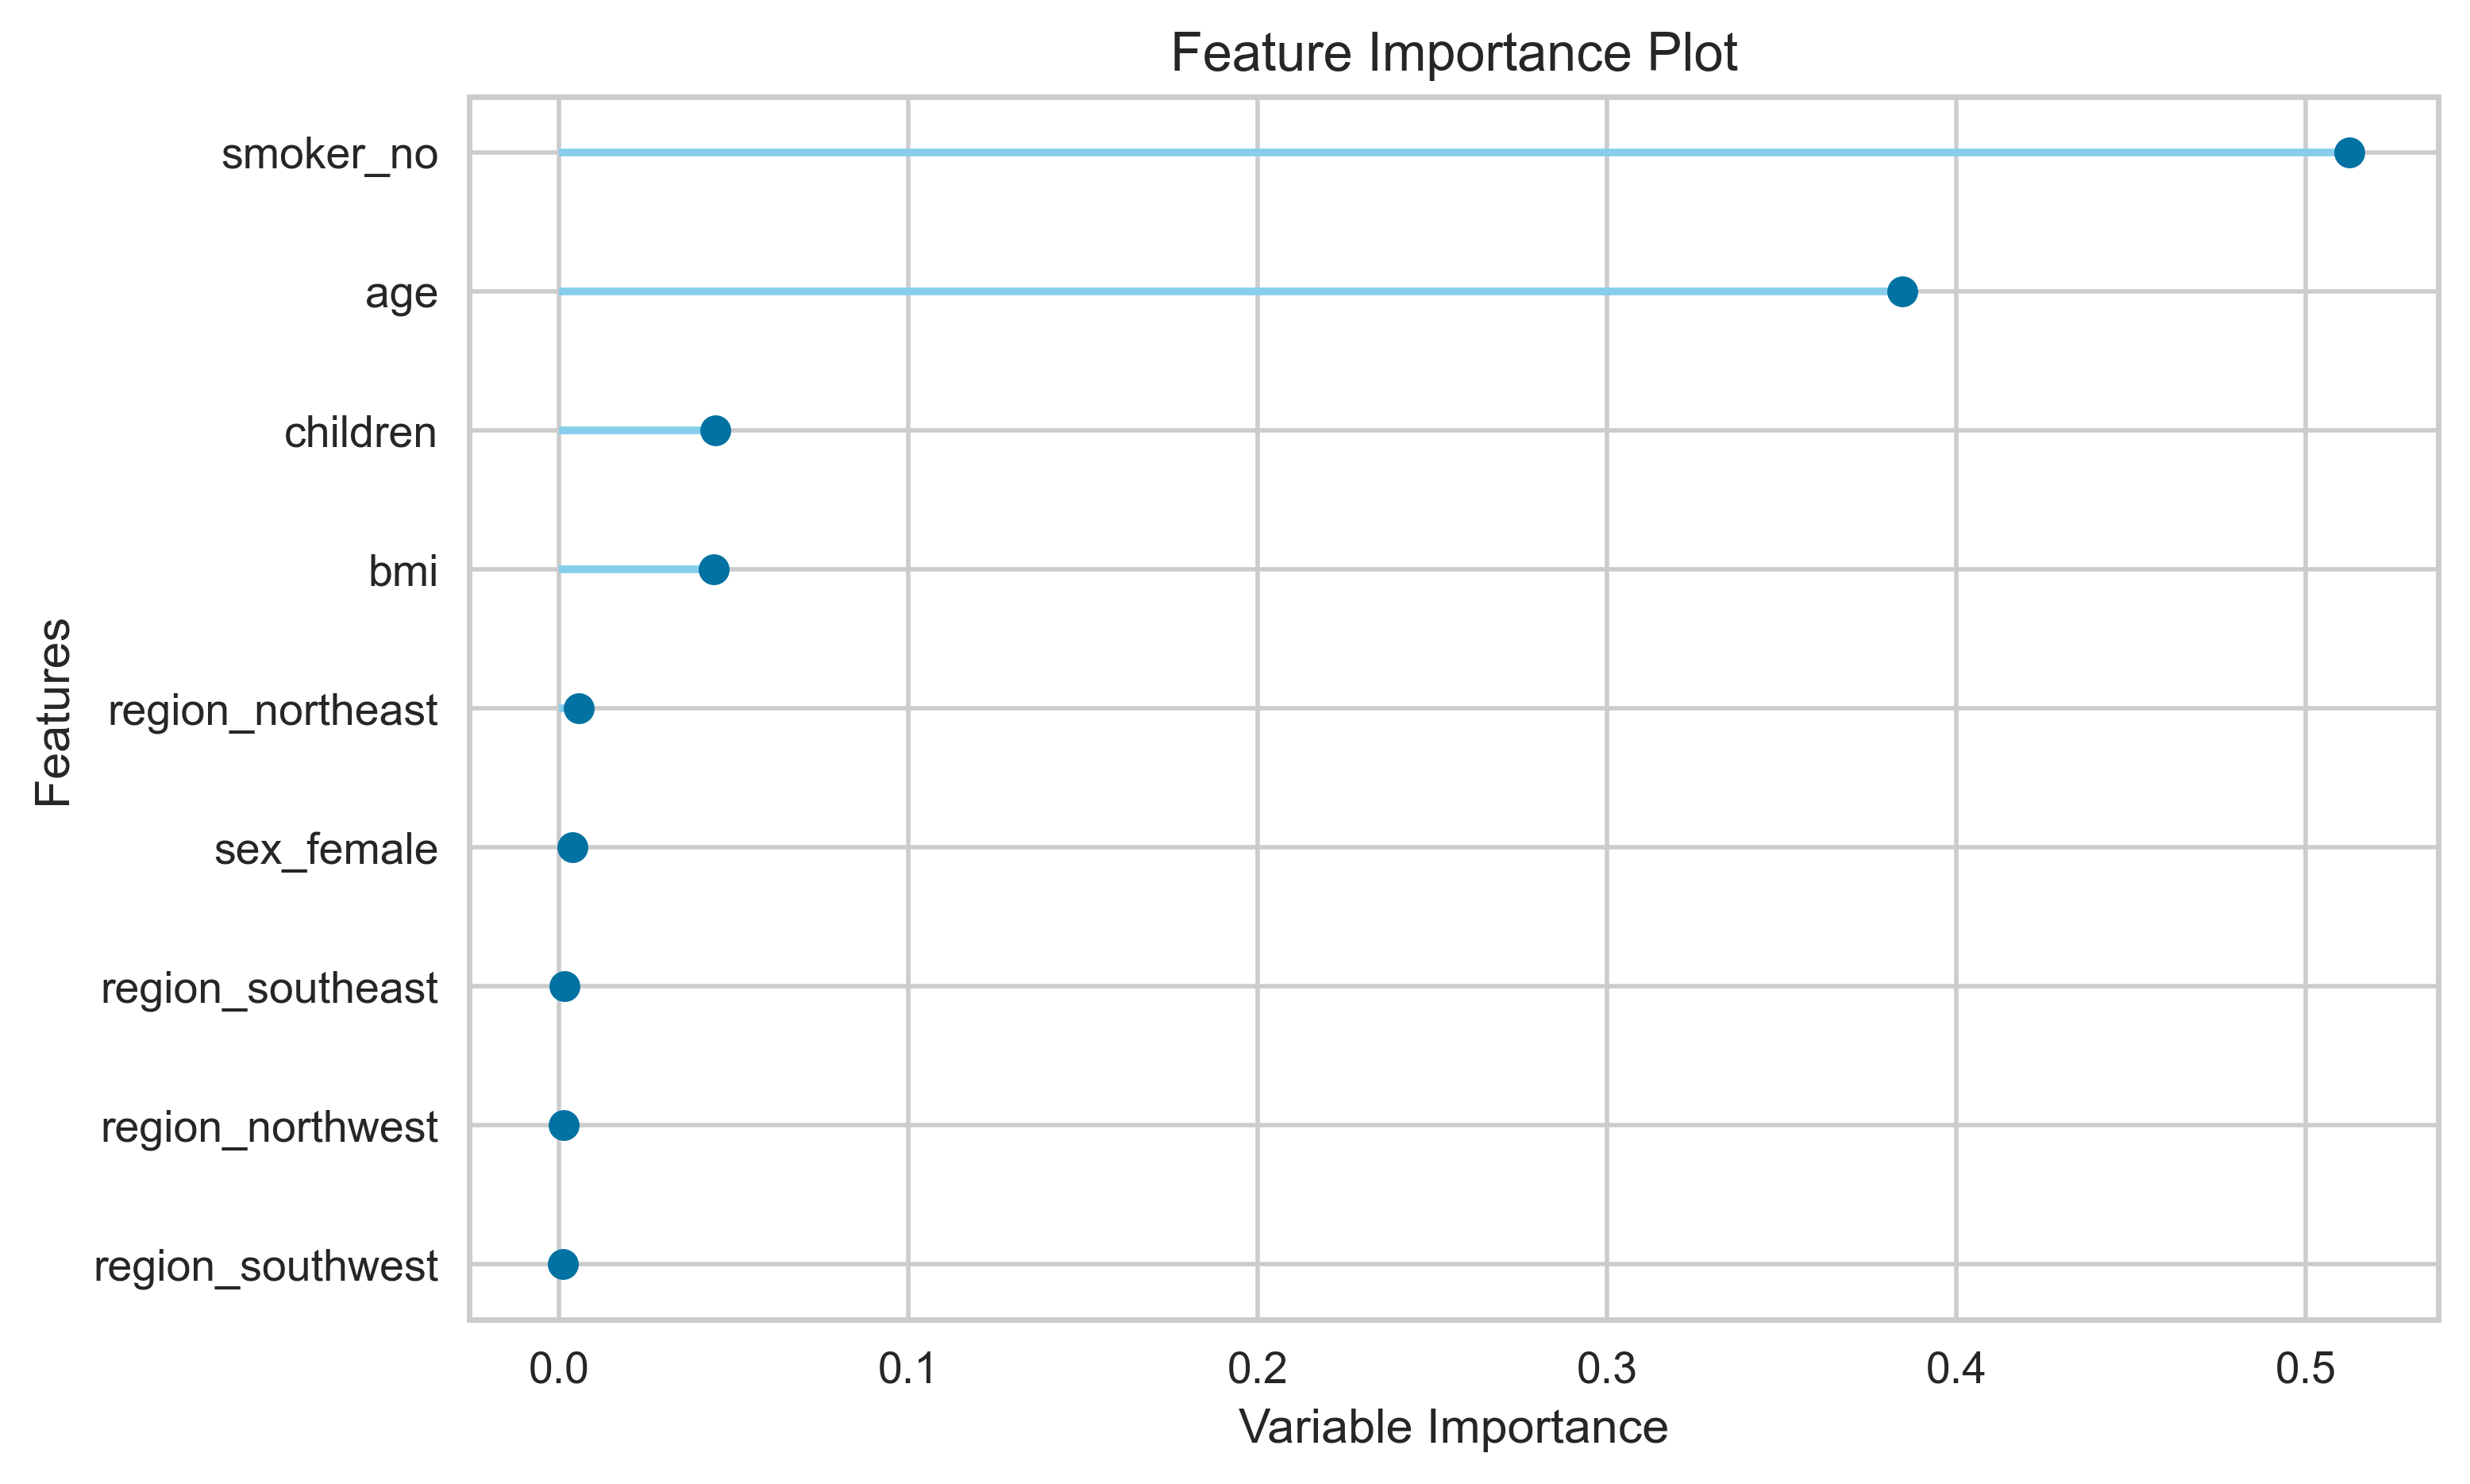

In [17]:
plot_model(tuned_model, "feature", scale=4)


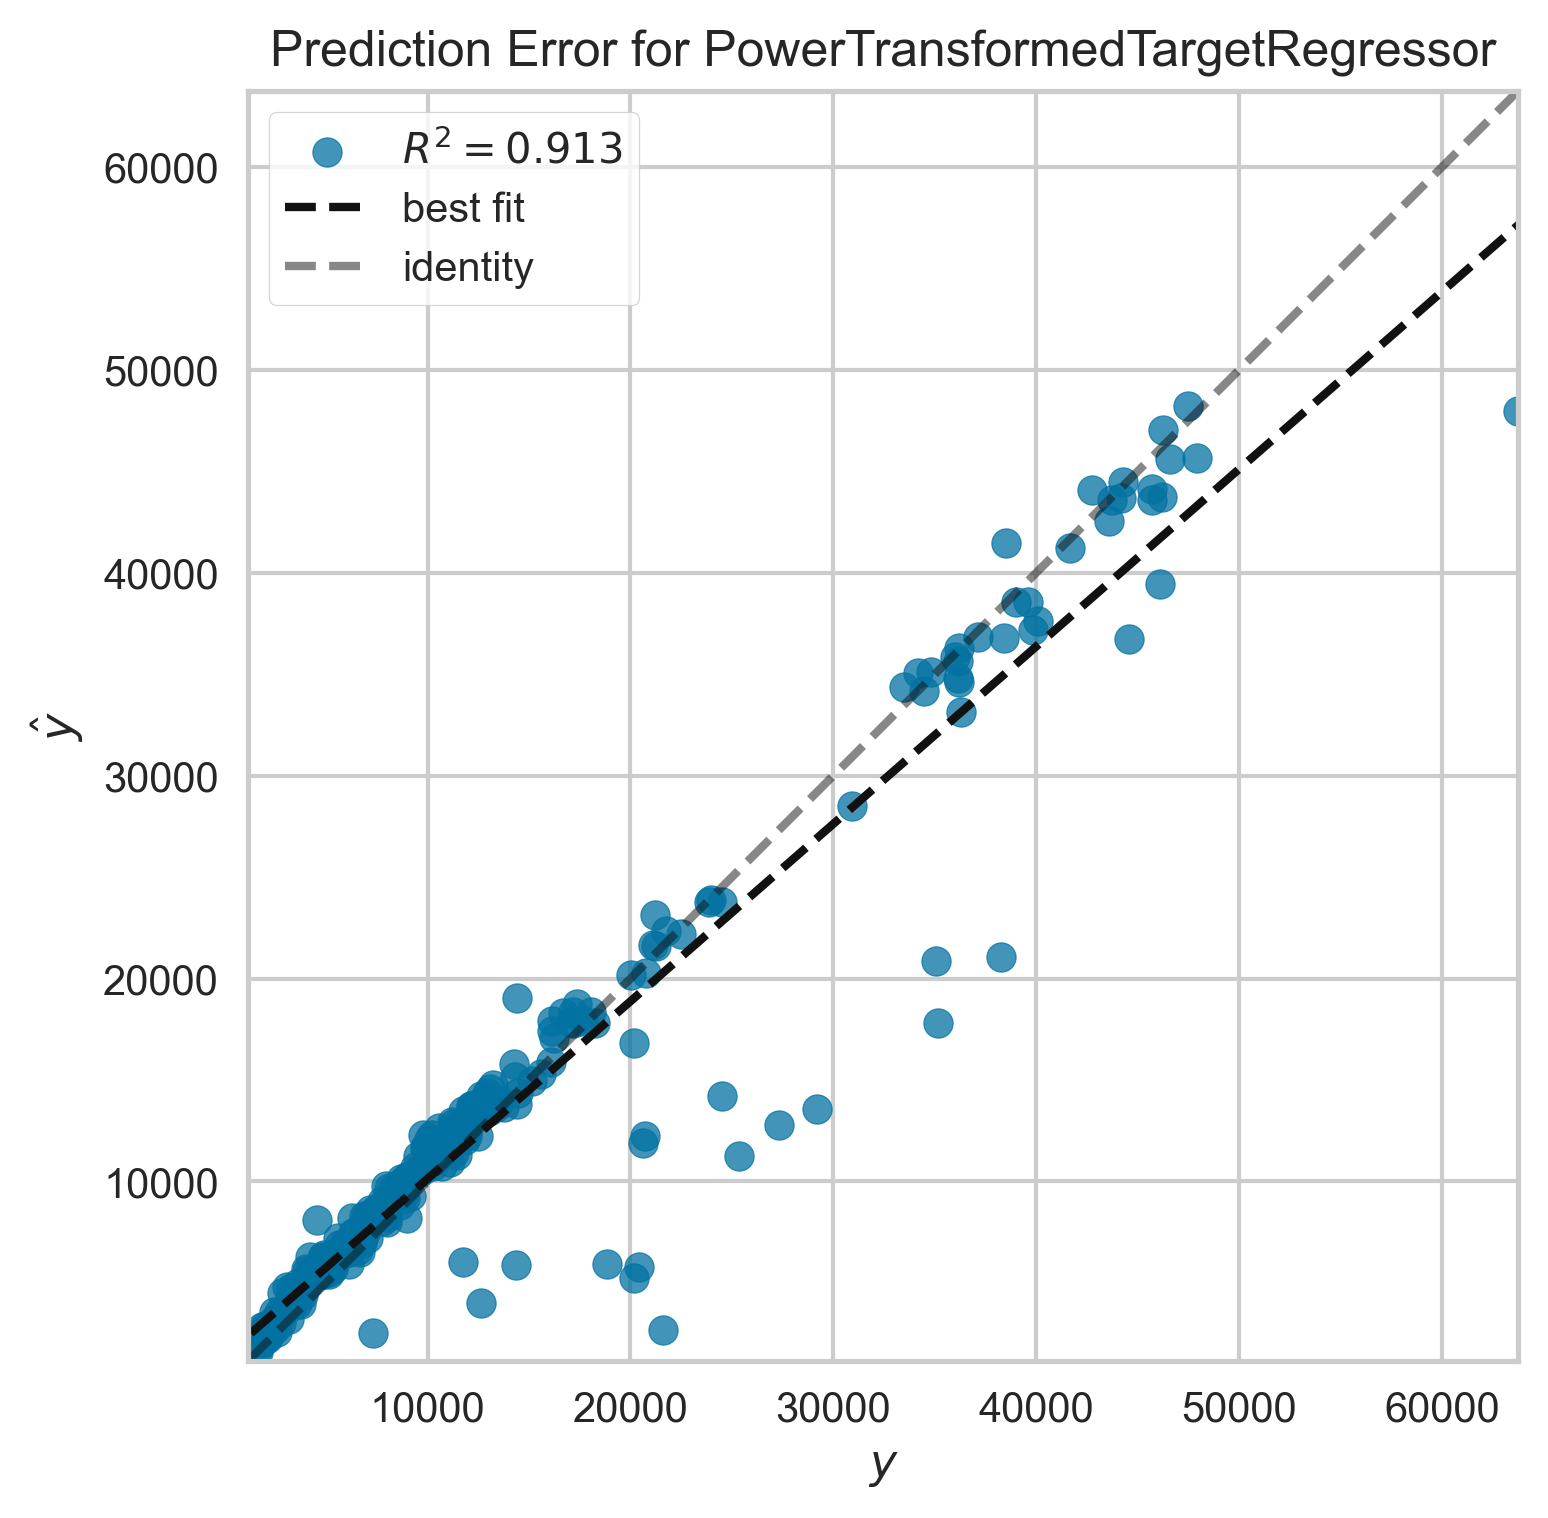

In [18]:
plot_model(tuned_model, "error")


In [19]:
final_model = finalize_model(tuned_model)
save_model(final_model, "regression_model_2023-04-09")


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['smoker', 'sex',
                                                             'region'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['age', 'bmi',
                                                           'children'],
                                       target='charges', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=No...
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                 